In [20]:
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from hyperopt import hp
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
warnings.filterwarnings('ignore')

In [21]:
df = pd.read_csv('./cancer_dataset_ver1.csv')
X = df.iloc[:,:-1]
y = df.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf_clf = RandomForestClassifier(max_depth = 100)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
score = accuracy_score(y_test, pred)
print("RandomForest정확도: ", np.round(score,4))

RandomForest정확도:  0.7529


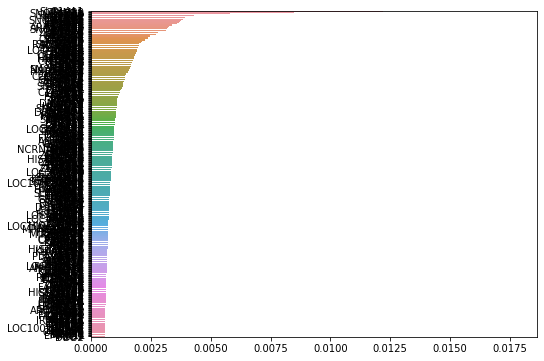

<class 'pandas.core.series.Series'>
Index: 500 entries, SLC14A1 to DDB2
Series name: None
Non-Null Count  Dtype  
--------------  -----  
500 non-null    float64
dtypes: float64(1)
memory usage: 24.0+ KB
None


In [22]:
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train.columns)
ftr_top500 = ftr_importances.sort_values(ascending=False)[:500]

plt.figure(figsize=(8,6))
sns.barplot(x=ftr_top500, y=ftr_top500.index)
plt.show()
print(ftr_top500.info())

In [23]:
df_ver2 = df[ftr_top500.index]
df_ver2['label'] = df['label']
X = df_ver2.iloc[:,:-1]
y = df_ver2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
rf_clf = RandomForestClassifier(max_depth = 100)
rf_clf.fit(X_train, y_train)
pred = rf_clf.predict(X_test)
score = accuracy_score(y_test, pred)
print("RandomForest정확도: ", np.round(score,4))

RandomForest정확도:  0.8118


In [24]:
#df = pd.read_csv('./cancer_dataset_ver1.csv')
X = df_ver2.iloc[:,:-1]
y = df_ver2.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1)

lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)
evals = [(X_tr,y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr, early_stopping_rounds = 100, eval_metric="logloss", eval_set = evals, verbose=True)
preds = lgbm_wrapper.predict(X_test)
score = accuracy_score(y_test, preds)
print("LGBM정확도: ", np.round(score,4))

[1]	training's binary_logloss: 0.623234	valid_1's binary_logloss: 0.679752
[2]	training's binary_logloss: 0.596087	valid_1's binary_logloss: 0.657697
[3]	training's binary_logloss: 0.571822	valid_1's binary_logloss: 0.636406
[4]	training's binary_logloss: 0.550326	valid_1's binary_logloss: 0.626967
[5]	training's binary_logloss: 0.530222	valid_1's binary_logloss: 0.620791
[6]	training's binary_logloss: 0.511341	valid_1's binary_logloss: 0.605226
[7]	training's binary_logloss: 0.491397	valid_1's binary_logloss: 0.597869
[8]	training's binary_logloss: 0.475802	valid_1's binary_logloss: 0.592859
[9]	training's binary_logloss: 0.458985	valid_1's binary_logloss: 0.591038
[10]	training's binary_logloss: 0.44267	valid_1's binary_logloss: 0.591731
[11]	training's binary_logloss: 0.427815	valid_1's binary_logloss: 0.585163
[12]	training's binary_logloss: 0.414046	valid_1's binary_logloss: 0.580796
[13]	training's binary_logloss: 0.402861	valid_1's binary_logloss: 0.574431
[14]	training's binary

[117]	training's binary_logloss: 0.0211488	valid_1's binary_logloss: 0.513233
[118]	training's binary_logloss: 0.0206534	valid_1's binary_logloss: 0.517094
[119]	training's binary_logloss: 0.0201837	valid_1's binary_logloss: 0.518642
[120]	training's binary_logloss: 0.019655	valid_1's binary_logloss: 0.515689
[121]	training's binary_logloss: 0.0191245	valid_1's binary_logloss: 0.521182
[122]	training's binary_logloss: 0.0186805	valid_1's binary_logloss: 0.519995
[123]	training's binary_logloss: 0.01817	valid_1's binary_logloss: 0.5253
[124]	training's binary_logloss: 0.0177315	valid_1's binary_logloss: 0.523578
[125]	training's binary_logloss: 0.0172581	valid_1's binary_logloss: 0.526506
[126]	training's binary_logloss: 0.0167821	valid_1's binary_logloss: 0.527754
[127]	training's binary_logloss: 0.0162839	valid_1's binary_logloss: 0.525375
[128]	training's binary_logloss: 0.0158847	valid_1's binary_logloss: 0.522265
[129]	training's binary_logloss: 0.0154787	valid_1's binary_logloss: 

In [12]:
lgbm_search_space = {'num_leaves': hp.quniform('num_leaves', 32, 64, 1),
                     'max_depth': hp.quniform('max_depth', 100, 160, 1),
                     'min_child_samples': hp.quniform('min_child_samples', 60, 100, 1),
                     'subsample': hp.uniform('subsample', 0.7, 1),
                     'learning_rate': hp.uniform('learning_rate', 0.01, 0.2)
                    }

In [13]:
def objective_func(search_space):
    lgbm_clf =  LGBMClassifier(n_estimators=100, num_leaves=int(search_space['num_leaves']),
                               max_depth=int(search_space['max_depth']),
                               min_child_samples=int(search_space['min_child_samples']), 
                               subsample=search_space['subsample'],
                               learning_rate=search_space['learning_rate'])
    # 3개 k-fold 방식으로 평가된 roc_auc 지표를 담는 list
    accuracy_score = []
    
    # 3개 k-fold방식 적용 
    kf = KFold(n_splits=3)
    # X_train을 다시 학습과 검증용 데이터로 분리
    for tr_index, val_index in kf.split(X_train):
        # kf.split(X_train)으로 추출된 학습과 검증 index값으로 학습과 검증 데이터 세트 분리 
        X_tr, y_tr = X_train.iloc[tr_index], y_train.iloc[tr_index]
        X_val, y_val = X_train.iloc[val_index], y_train.iloc[val_index]

        # early stopping은 30회로 설정하고 추출된 학습과 검증 데이터로 XGBClassifier 학습 수행. 
        lgbm_clf.fit(X_tr, y_tr, early_stopping_rounds=30, eval_metric="logross",
           eval_set=[(X_tr, y_tr), (X_val, y_val)])

        # 1로 예측한 확률값 추출후 roc auc 계산하고 평균 roc auc 계산을 위해 list에 결과값 담음.
        score = accuracy_score(y_val, lgbm_clf.predict_proba(X_val)[:, 1]) 
        accuracy_score.append(score)
    
    # 3개 k-fold로 계산된 roc_auc값의 평균값을 반환하되, 
    # HyperOpt는 목적함수의 최소값을 위한 입력값을 찾으므로 -1을 곱한 뒤 반환.
    return -1*np.mean(roc_auc_list)